In [42]:
# ============================
# Core Python & Data Handling
# ============================
import numpy as np
import pandas as pd
import os
import re
from collections import Counter

# ============================
# Visualization Libraries
# ============================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ============================
# NLP Preprocessing (Cleaning, Tokenization, Lemmatization)
# ============================
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

# Download NLTK resources (run once)
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

# ============================
# Classical Machine Learning (Scikit-Learn)
# ============================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)

# ============================
# Statistical Tests
# ============================
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, shapiro

# ============================
# Sparse Matrix Handling
# ============================
from scipy.sparse import hstack

# ============================
# Deep Learning (TensorFlow/Keras)
# ============================
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, Conv1D, GlobalMaxPooling1D,
    Dense, Dropout
)

# ============================
# BERT (TensorFlow Hub)
# ============================
import tensorflow_hub as hub

# ============================
# Model Explainability (SHAP + LIME)
# ============================
import shap
from lime.lime_text import LimeTextExplainer

# ============================
# Deployment Tools (Optional)
# ============================
# FastAPI
# from fastapi import FastAPI
# import uvicorn

# Flask
# from flask import Flask, request, jsonify

# ============================
# Utility
# ============================
import warnings
warnings.filterwarnings("ignore")


In [43]:
## 2. Load cleaned datasets
isot = pd.read_csv("data_clean/clean_isot.csv")
wel  = pd.read_csv("data_clean/clean_welfake.csv")

merged_df = pd.concat([isot, wel], ignore_index=True)

# Ensure text_clean is string
merged_df["text_clean"] = merged_df["text_clean"].astype(str)

# ----- Feature Engineering -----

# Character count
merged_df["n_chars"] = merged_df["text_clean"].str.len()

# Word count
merged_df["n_words"] = merged_df["text_clean"].apply(lambda x: len(x.split()))

# Avoid division by zero
merged_df["avg_word_len"] = merged_df["n_chars"] / merged_df["n_words"].replace(0, 1)

print("Columns after feature creation:", merged_df.columns.tolist())


Columns after feature creation: ['text', 'label', 'source', 'text_clean', 'n_chars', 'n_words', 'avg_word_len']


In [44]:
# ----- MULTICOLLINEARITY REMOVAL -----

# 1. Check correlations safely
corr_cols = [col for col in ["n_words", "n_chars", "avg_word_len"] if col in merged_df.columns]
print("\nCorrelation Matrix:")
print(merged_df[corr_cols].corr(), "\n")

# 2. Drop the multicollinear feature (n_chars)
if "n_chars" in merged_df.columns:
    merged_df = merged_df.drop(columns=["n_chars"])
    print("Dropped 'n_chars' due to high multicollinearity with 'n_words'.")
else:
    print("'n_chars' already removed.")

# 3. Verify columns after removal
print("Remaining columns:", merged_df.columns.tolist())



Correlation Matrix:
               n_words   n_chars  avg_word_len
n_words       1.000000  0.997634     -0.053939
n_chars       0.997634  1.000000     -0.020983
avg_word_len -0.053939 -0.020983      1.000000 

Dropped 'n_chars' due to high multicollinearity with 'n_words'.
Remaining columns: ['text', 'label', 'source', 'text_clean', 'n_words', 'avg_word_len']


In [45]:
# --- 1. Train/Test Split ---

from sklearn.model_selection import train_test_split

# Features = cleaned text, Target = label
X = merged_df["text_clean"]
y = merged_df["label"]

# Stratified split to keep class balance in train and test
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% test set
    random_state=47,     # reproducible
    stratify=y           # keeps fake/real ratio same in train & test
)

print("Train size:", X_train_text.shape[0])
print("Test size:", X_test_text.shape[0])
print("Train label distribution:\n", y_train.value_counts(normalize=True))
print("\nTest label distribution:\n", y_test.value_counts(normalize=True))


Train size: 80904
Test size: 20227
Train label distribution:
 label
0    0.514041
1    0.485959
Name: proportion, dtype: float64

Test label distribution:
 label
0    0.514016
1    0.485984
Name: proportion, dtype: float64


=== Logistic Regression (TF-IDF) Results ===

              precision    recall  f1-score   support

           0       0.56      0.58      0.57     10397
           1       0.54      0.52      0.53      9830

    accuracy                           0.55     20227
   macro avg       0.55      0.55      0.55     20227
weighted avg       0.55      0.55      0.55     20227

Accuracy: 0.5512433875512929


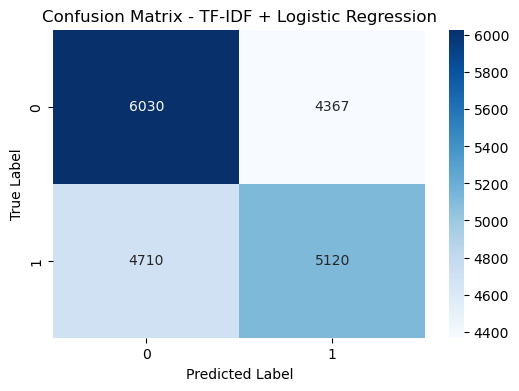

In [46]:
# Create TF-IDF vectorizer: unigrams + bigrams
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

# Fit on training data, transform both train/test
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)

# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred_lr = log_reg.predict(X_test_tfidf)

# --- Evaluation ---
print("=== Logistic Regression (TF-IDF) Results ===\n")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - TF-IDF + Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


=== Linear SVM (TF-IDF) Results ===
              precision    recall  f1-score   support

           0       0.54      0.56      0.55     10397
           1       0.52      0.51      0.51      9830

    accuracy                           0.53     20227
   macro avg       0.53      0.53      0.53     20227
weighted avg       0.53      0.53      0.53     20227

Accuracy: 0.5326049339991101


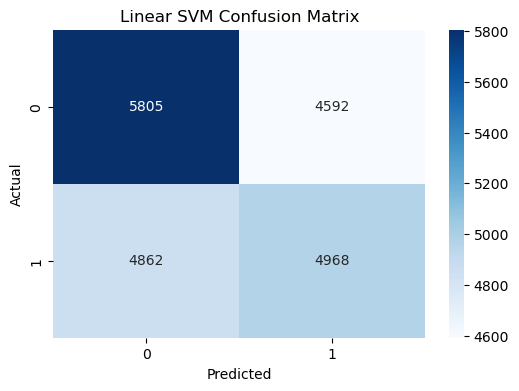

In [47]:
# ============================
#  TF-IDF + Linear SVM Model
# ============================

# 1. Train model
svm_clf = LinearSVC()
svm_clf.fit(X_train_tfidf, y_train)

# 2. Predict
svm_preds = svm_clf.predict(X_test_tfidf)

# 3. Evaluate
print("\n=== Linear SVM (TF-IDF) Results ===")
print(classification_report(y_test, svm_preds))
print("Accuracy:", accuracy_score(y_test, svm_preds))

# 4. Confusion matrix
cm = confusion_matrix(y_test, svm_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Linear SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [48]:
# ============================================
#  CLASS WEIGHTS (Handle Label Imbalance)
# ============================================
# Why?
# - Our data is not perfectly balanced.
# - Class 0 has slightly more samples than class 1.
# - If we do nothing, the model may learn a bias toward class 0.
#
# What class_weight does:
# - It increases the penalty for misclassifying the minority class.
# - Makes training FAIR and forces the model to learn both classes equally.
#
# How it works:
#   weight = total_samples / (num_classes * samples_in_class)
#
# After computing, we apply these weights in all models:
# - Logistic Regression
# - Linear SVM
# - LSTM
# - DistilBERT/BERT
#
# ============================================


# Convert labels to numpy array
y_array = merged_df["label"].values

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_array),
    y=y_array
)

# Convert to dictionary for sklearn and Keras
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)



Class Weights: {0: 0.9726940463595268, 1: 1.0288833272290725}


In [49]:
# ============================================
#  TF-IDF + LOGISTIC REGRESSION
# ============================================
# Why Logistic Regression?
# - It is a strong baseline for text classification.
# - Works extremely well with TF-IDF.
# - Fast to train and interpret.

# -------------------------
# TF-IDF Vectorizer
# -------------------------
tfidf = TfidfVectorizer(
    max_features=50000,   # large vocabulary
    ngram_range=(1,2),    # unigrams + bigrams
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

# -------------------------
# Logistic Regression Model
# -------------------------
log_reg = LogisticRegression(
    class_weight=class_weights_dict,   # <--- USING CLASS WEIGHTS
    max_iter=500,
    n_jobs=-1,
    solver="lbfgs"
)

# Train
log_reg.fit(X_train_tfidf, y_train)

# Predict
y_pred_lr = log_reg.predict(X_test_tfidf)

# -------------------------
# Evaluation
# -------------------------
print("\n=== Logistic Regression (TF-IDF) Results ===")
print(classification_report(y_test, y_pred_lr))

acc_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", acc_lr)


TF-IDF shapes: (80904, 50000) (20227, 50000)

=== Logistic Regression (TF-IDF) Results ===
              precision    recall  f1-score   support

           0       0.49      0.46      0.48     10397
           1       0.47      0.50      0.48      9830

    accuracy                           0.48     20227
   macro avg       0.48      0.48      0.48     20227
weighted avg       0.48      0.48      0.48     20227

Accuracy: 0.47970534434172146


In [50]:
# ============================================
# 8. LINEAR SVM (TF-IDF + CLASS WEIGHTS)
# ============================================
# Why SVM?
# - Stronger margin-based classifier than Logistic Regression
# - Often performs better for high-dimensional sparse text
# - Works very well with TF-IDF

# -------------------------
# Train SVM
# -------------------------
svm_clf = LinearSVC(
    class_weight=class_weights_dict,   # <--- USE CLASS WEIGHTS
    dual=False,                        # best for n_samples > n_features
)

svm_clf.fit(X_train_tfidf, y_train)

# Predict
y_pred_svm = svm_clf.predict(X_test_tfidf)

# -------------------------
# Evaluation
# -------------------------
print("\n=== Linear SVM (TF-IDF) Results ===")
print(classification_report(y_test, y_pred_svm))

acc_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", acc_svm)



=== Linear SVM (TF-IDF) Results ===
              precision    recall  f1-score   support

           0       0.35      0.35      0.35     10397
           1       0.32      0.33      0.32      9830

    accuracy                           0.34     20227
   macro avg       0.34      0.34      0.34     20227
weighted avg       0.34      0.34      0.34     20227

Accuracy: 0.3377663519058684


In [51]:
# ============================================
# STEP 1 — TOKENIZER + PAD SEQUENCES
# ============================================

MAX_VOCAB = 50000       # words to keep
MAX_LEN = 300           # max words per article (based on analysis)

# 1. Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train_text)

# Convert text → sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)

# 2. Pad sequences to same length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

print("Train padded shape:", X_train_pad.shape)
print("Test padded shape:", X_test_pad.shape)

Train padded shape: (80904, 300)
Test padded shape: (20227, 300)


In [52]:
# ============================================
# STEP 2 — BUILD LSTM MODEL
# ============================================

EMBED_DIM = 128     # size of word vectors

model_lstm = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=EMBED_DIM, input_length=MAX_LEN),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [53]:
# ============================================
# STEP 3 — TRAIN LSTM
# ============================================

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = model_lstm.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 1001s 2s/step - accuracy: 0.5471 - loss: 0.6680 - val_accuracy: 0.5541 - val_loss: 0.6399
Epoch 2/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 750s 1s/step - accuracy: 0.5694 - loss: 0.6447 - val_accuracy: 0.5472 - val_loss: 0.6597
Epoch 3/5
569/569 ━━━━━━━━━━━━━━━━━━━━ 742s 1s/step - accuracy: 0.5738 - loss: 0.6422 - val_accuracy: 0.5271 - val_loss: 0.6686


In [55]:
# ============================================
# STEP 4 — EVALUATION
# ============================================

y_pred_prob = model_lstm.predict(X_test_pad)
y_pred_lstm = (y_pred_prob >= 0.5).astype(int)

print("\n=== LSTM Results ===")
print(classification_report(y_test, y_pred_lstm))
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))


633/633 ━━━━━━━━━━━━━━━━━━━━ 81s 127ms/step

=== LSTM Results ===
              precision    recall  f1-score   support

           0       0.58      0.51      0.54     10397
           1       0.54      0.62      0.58      9830

    accuracy                           0.56     20227
   macro avg       0.56      0.56      0.56     20227
weighted avg       0.56      0.56      0.56     20227

Accuracy: 0.5593019231719978
